<a href="https://colab.research.google.com/github/ankanghosh/breast_cancer_prediction_using_logistic_regression/blob/main/BreastCancerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pds
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Fetch and read the data

In [ ]:
# Import the dataset from Google Drive.
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Datasets/Kaggle/cancer_data.csv'
raw_dataset = pds.read_csv(data_path, na_values='?',
                         sep=',', skipinitialspace=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = raw_dataset.copy()
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Clean the data

In [ ]:
# Drop features that are not important.
dataset.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Check if there are unknown values.
dataset.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [ ]:
# Check if there are duplicate rows.
dataset.duplicated().sum()

0

We will use 'daignosis' as the predicted or target variable. Before we could do that, we have convert the categorical values under the 'diagnosis' column to binary values.

In [ ]:
dataset['diagnosis'] = dataset['diagnosis'].map({'B': 0, 'M': 1})

# Inspect the data

In [ ]:
# Confirm the shape of the DataFrame.
dataset.shape

(569, 31)

In [ ]:
# Inspect the data types.
dataset.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [ ]:
# Explore the dataset further.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

# Split the data for training

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
# Explore the characteristics of the training data.
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
diagnosis,455.0,0.369231,0.483128,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,455.0,14.038009,3.443339,6.981000,11.665000,13.270000,15.815000,28.11000
texture_mean,455.0,19.254352,4.356593,9.710000,16.175000,18.800000,21.635000,39.28000
perimeter_mean,455.0,91.345407,23.756012,43.790000,75.015000,85.790000,104.200000,188.50000
area_mean,455.0,645.170549,336.691085,143.500000,417.450000,541.800000,785.600000,2499.00000
smoothness_mean,455.0,0.096414,0.014029,0.065760,0.085925,0.095920,0.105200,0.16340
compactness_mean,455.0,0.103311,0.052823,0.026500,0.062985,0.089630,0.130400,0.34540
concavity_mean,455.0,0.087379,0.080251,0.000000,0.028360,0.058350,0.126950,0.42680
concave points_mean,455.0,0.048025,0.038383,0.000000,0.019685,0.032640,0.068670,0.20120
symmetry_mean,455.0,0.181355,0.027769,0.106000,0.162000,0.179100,0.195650,0.30400


In [ ]:
train_dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
512,1,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,...,16.41,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090
457,0,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,...,14.35,34.23,91.29,632.9,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788
439,0,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,...,14.91,19.31,96.53,688.9,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710
298,0,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,...,16.22,25.26,105.80,819.7,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676
37,0,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,...,13.30,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169


# Separate out the labels from the features


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [ ]:
# Drop the target variable or feature we are trying to predict from the training data.
train_features_input = train_features.drop(['diagnosis'], axis=1)
train_features_labels = train_features['diagnosis'] # Training labels.

# Drop the target variable or feature we are trying to predict from the test data.
test_features_input = test_features.drop(['diagnosis'], axis=1)
test_features_labels = test_features['diagnosis'] # Test labels.

# Normalization of the training data

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features_input))
dataset_normalized = normalizer(train_features_input)
print(normalizer.mean.numpy())

[[ 14.038  19.254  91.345 645.171   0.096   0.103   0.087   0.048   0.181
    0.063   0.402   1.213   2.837  39.252   0.007   0.025   0.032   0.012
    0.021   0.004  16.144  25.607 106.28  862.649   0.133   0.251   0.269
    0.113   0.291   0.084]]


In [ ]:
# Compare the original and normalized versions of the first example.
first = np.array(train_features_input[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 13.4   20.52  88.64 556.7    0.11   0.15   0.14   0.08   0.21   0.07
    0.39   0.93   3.09  33.67   0.01   0.02   0.03   0.01   0.02   0.
   16.41  29.66 113.3  844.4    0.16   0.39   0.51   0.21   0.36   0.11]]

Normalized: [[-0.19  0.29 -0.11 -0.26  1.01  0.83  0.71  0.88  1.09  1.44 -0.04 -0.52
   0.13 -0.14 -0.56 -0.15  0.08  0.24 -0.44  0.07  0.06  0.66  0.22 -0.03
   1.1   0.88  1.16  1.41  1.08  1.55]]


# Dimensionality Reduction and Feature Engineering using Principal Component Analysis (PCA)

We will use PCA for dimensionality reduction. We will use the new principal components created by PCA that are linear combinations of the original features and capture the underlying structure of the data more effectively than the original features.

In [ ]:
# Perform PCA.
pca_initial = PCA(n_components=None) # Select all of the components to start with.
dataset_pca = pca_initial.fit_transform(dataset_normalized)

# Get the Explained Variance Ratio to select the number of PCA components to use.
print("Explained Variance Ratio:")
print(pca_initial.explained_variance_ratio_)

Explained Variance Ratio:
[0.444 0.187 0.101 0.067 0.054 0.038 0.021 0.015 0.014 0.011 0.009 0.009
 0.008 0.005 0.003 0.003 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.    0.    0.    0.    0.   ]


We will use a scree plot to decide on the number of components for PCA.

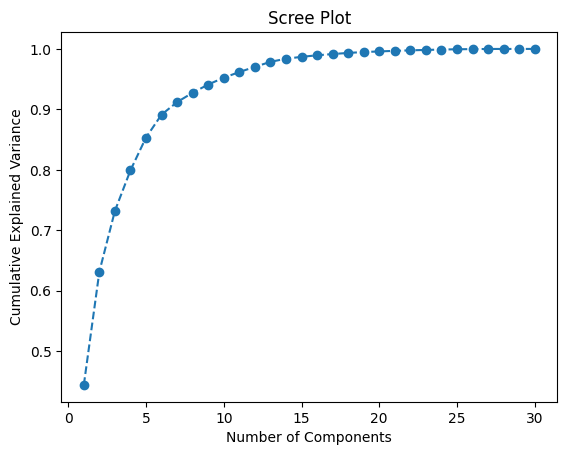

In [ ]:
# Cumulative variance of the principal components.
cum_var = np.cumsum(pca_initial.explained_variance_ratio_)

# Scree plot.
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [ ]:
# Choose number of components based on the scree plot and the Explained Variance Ratio.
num_components = 12 # 12 corresponds to approximately 95% of the Cumulative Explained Variance Ratio.

We still have to refit the PCA with the chosen components.

In [ ]:
# Refit PCA with the chosen number of components.
pca_final = PCA(n_components=num_components)
dataset_pca_selected = pca_final.fit_transform(dataset_normalized)

In [ ]:
# dataset_pca_selected now contains the PCA-transformed data with the selected components.
print("PCA-transformed data shape with selected components:", dataset_pca_selected.shape)

PCA-transformed data shape with selected components: (455, 12)


In [ ]:
# Convert the PCA-transformed NumPy array into a DataFrame for processing.
dataset_pca_selected = pds.DataFrame(dataset_pca_selected)
dataset_pca_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       455 non-null    float64
 1   1       455 non-null    float64
 2   2       455 non-null    float64
 3   3       455 non-null    float64
 4   4       455 non-null    float64
 5   5       455 non-null    float64
 6   6       455 non-null    float64
 7   7       455 non-null    float64
 8   8       455 non-null    float64
 9   9       455 non-null    float64
 10  10      455 non-null    float64
 11  11      455 non-null    float64
dtypes: float64(12)
memory usage: 42.8 KB


# Normalization of the test data

We will have to apply normalization and PCA to the test data to ensure that the testing data is processed in the same way as the training data. The consistency is essential for the model to make generalize well on new, unseen data.

In [ ]:
# Normalize the test data.
dataset_test_normalized = normalizer(test_features_input)

# Transform the test data.
dataset_test_pca = pca_final.transform(dataset_test_normalized)

# Logistic Regression Model

We will use a single-layer neural network for classification.

In [ ]:
# Create the single-layer neural network model. We'll use lor to denote logistic regression.
lor_model = tf.keras.Sequential([
    layers.Dense(1, input_dim=dataset_pca_selected.shape[1], activation='sigmoid'), # For binary classification.
])

In [ ]:
# Compile the model.
lor_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Investigate the model.
lor_model.summary()
lor_model.predict(dataset_pca_selected[:10])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 226ms/step


array([[0.169],
       [0.369],
       [0.673],
       [0.768],
       [0.798],
       [0.729],
       [0.56 ],
       [0.914],
       [0.993],
       [0.978]], dtype=float32)

We will set up an early stopping callback to save resources and stop training when there is no improvement in terms of minimizing the loss and improving the accuracy of the model.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor the validation loss.
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
# Fit the model with the training data.
%%time
history = lor_model.fit(
    dataset_pca_selected,
    train_features_labels,
    epochs=250,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/250
46/46 [==============================] - 2s 13ms/step - loss: 2.0770 - accuracy: 0.1401 - val_loss: 1.8128 - val_accuracy: 0.1319
Epoch 2/250
46/46 [==============================] - 0s 5ms/step - loss: 1.9443 - accuracy: 0.1484 - val_loss: 1.6942 - val_accuracy: 0.1648
Epoch 3/250
46/46 [==============================] - 0s 5ms/step - loss: 1.8160 - accuracy: 0.1511 - val_loss: 1.5810 - val_accuracy: 0.1868
Epoch 4/250
46/46 [==============================] - 0s 7ms/step - loss: 1.6913 - accuracy: 0.1676 - val_loss: 1.4688 - val_accuracy: 0.2198
Epoch 5/250
46/46 [==============================] - 0s 7ms/step - loss: 1.5703 - accuracy: 0.1786 - val_loss: 1.3619 - val_accuracy: 0.2308
Epoch 6/250
46/46 [==============================] - 0s 4ms/step - loss: 1.4545 - accuracy: 0.1868 - val_loss: 1.2599 - val_accuracy: 0.2418
Epoch 7/250
46/46 [==============================] - 0s 11ms/step - loss: 1.3432 - accuracy: 0.2060 - val_loss: 1.1632 - val_accuracy: 0.2527
Epoch 8/250

# Performance Evaluation

Calculate the test loss and test accuracy of the model.

In [ ]:
test_loss, test_accuracy = lor_model.evaluate(dataset_test_pca, test_features_labels, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

4/4 - 0s - loss: 0.0431 - accuracy: 0.9912 - 183ms/epoch - 46ms/step
Test Loss: 0.04308173805475235
Test Accuracy: 0.9912280440330505


Let's plot the accuracy and loss for the training and validation data and investigate if we are overfitting the data.

In [ ]:
# Function to plot the training and validation accuracy.
def plot_accuracy(history):
  # Plot the training & validation accuracy values.
  plt.figure(figsize=(12, 4))
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

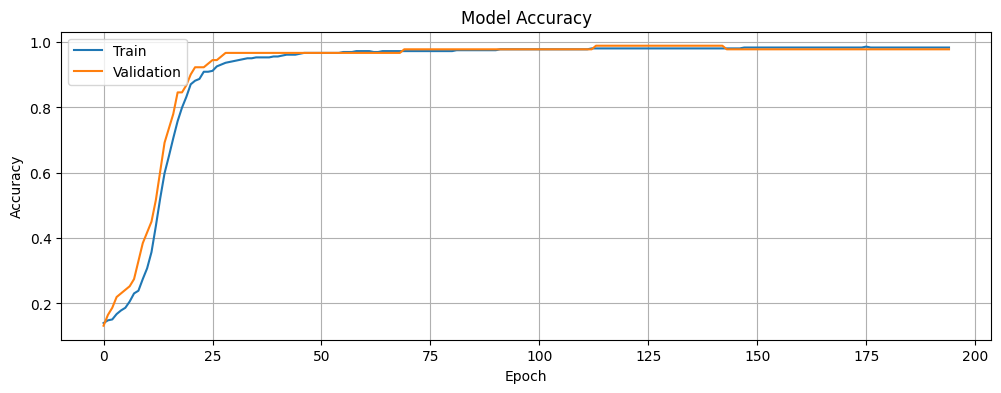

In [ ]:
plot_accuracy(history)

In [ ]:
# Function to plot the training and validation loss.
def plot_loss(history):
  # Plot the training & validation loss values.
  plt.figure(figsize=(12, 4))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

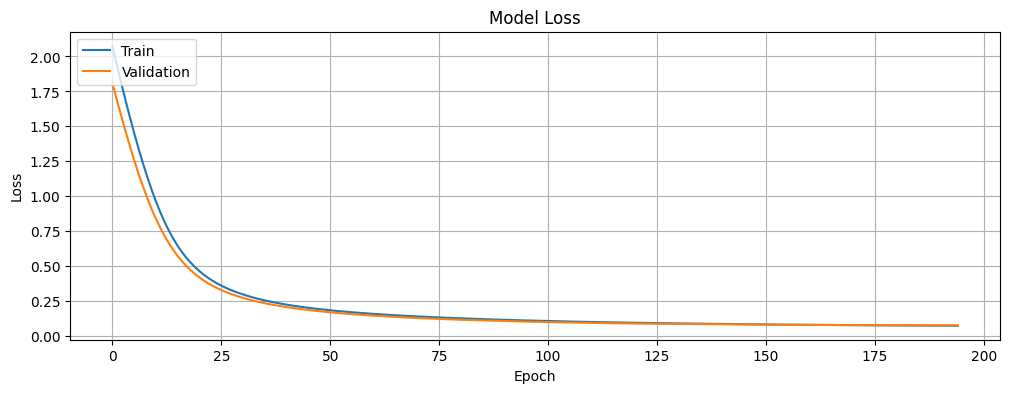

In [ ]:
plot_loss(history)

Plot the confusion matrix to investigate how the model performs in terms of the false positives and false negatives.

In [ ]:
# Predict the classes.
y_pred = lor_model.predict(dataset_test_pca)
y_pred_classes = (y_pred > 0.5).astype("int32")

4/4 [==============================] - 0s 3ms/step


In [ ]:
# Confusion matrix.
cm = confusion_matrix(test_features_labels, y_pred_classes)

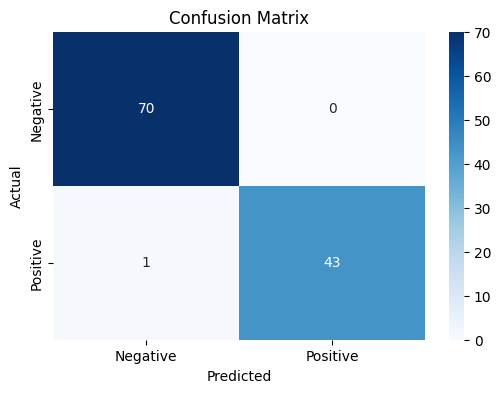

In [ ]:
# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()